# FloPy
### UZF example
Demonstrates functionality of the flopy UZF module using the example from [Niswonger and others (2006)](http://pubs.usgs.gov/tm/2006/tm6a19/). This is the same as the SFR example problem from Prudic and others (2004;
p. 13–19), except the UZF package replaces the ET and RCH packages.

#### Problem description:

* Grid dimensions: 1 Layer, 15 Rows, 10 Columns  
* Stress periods: 12  
* Units are in seconds and days
* Flow package: LPF  
* Stress packages: SFR, GHB, UZF 
* Solver: SIP  

<img src="./img/Niswonger2006_fig13.png" width="400" height="500"/>

In [1]:
import sys
sys.path.append('../..')
import glob
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf

%matplotlib inline

In [2]:
path = 'temp'
if not os.path.isdir(path):
    os.mkdirs(path)
gpth = os.path.join('..', 'data', 'mf2005_test', 'UZFtest2.*')
for f in glob.glob(gpth):
    shutil.copy(f, path)

### Load example dataset, skipping the UZF package

In [3]:
m = flopy.modflow.Modflow.load('UZFtest2.nam', version='mf2005', exe_name='mf2005', 
                               model_ws=path, load_only=['ghb', 'dis', 'bas6', 'oc', 'sip', 'lpf', 'sfr'])

In [4]:
m.external_fnames

['temp/UZFtest2.uzf1',
 'temp/UZFtest2.uzf2',
 'temp/UZFtest2.uzf3',
 'temp/UZFtest2.uzf4',
 'temp/UZFtest2.flw',
 'temp/UZFtest2.sg2',
 'temp/UZFtest2.sg3',
 'temp/UZFtest2.sg4',
 'temp/UZFtest2.sg5',
 'temp/UZFtest2.sg6',
 'temp/UZFtest2.sg7',
 'temp/UZFtest2.sg8',
 'temp/UZFtest2dv.sg9',
 'temp/UZFtest2.sg1',
 'temp/UZFtest2.uzfot']

In [5]:
rm = [True if '.uz' in f else False for f in m.external_fnames]

In [6]:
m.external_fnames = [f for i, f in enumerate(m.external_fnames) if not rm[i]]
m.external_fnames

['temp/UZFtest2.flw',
 'temp/UZFtest2.sg2',
 'temp/UZFtest2.sg3',
 'temp/UZFtest2.sg4',
 'temp/UZFtest2.sg5',
 'temp/UZFtest2.sg6',
 'temp/UZFtest2.sg7',
 'temp/UZFtest2.sg8',
 'temp/UZFtest2dv.sg9',
 'temp/UZFtest2.sg1']

In [7]:
m.external_binflag = [f for i, f in enumerate(m.external_binflag) if not rm[i]]
m.external_output = [f for i, f in enumerate(m.external_output) if not rm[i]]
m.external_units = [f for i, f in enumerate(m.external_output) if not rm[i]]

### `izufbnd` array  
* in the example, the UZF package **izufbnd** array is the same as the ibound

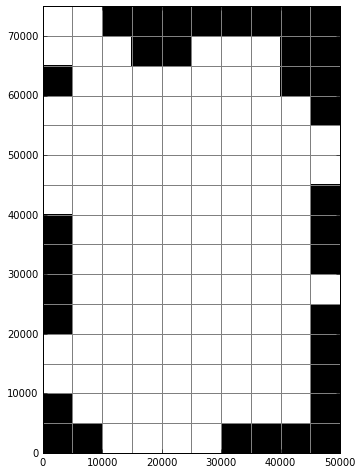

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=m)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()

### Set up the ```irunbnd``` array  
* read this in from an external file

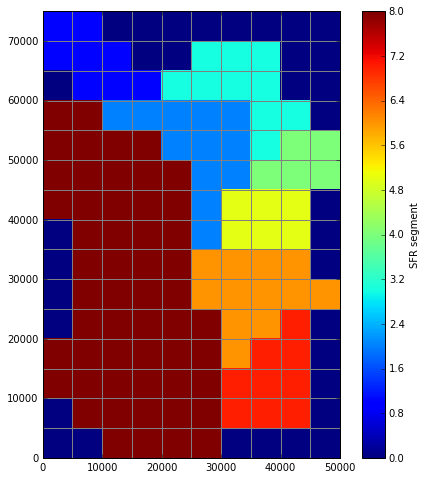

In [9]:
irnbndpth = os.path.join('..', 'data', 'uzf_examples', 'irunbnd.dat')
irunbnd = np.loadtxt(irnbndpth)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=m)
irunbndplt = modelmap.plot_array(irunbnd)
plt.colorbar(irunbndplt, ax=ax, label='SFR segment')
linecollection = modelmap.plot_grid()

### ``vks`` (unsaturated zone vertical hydraulic conductivity) array

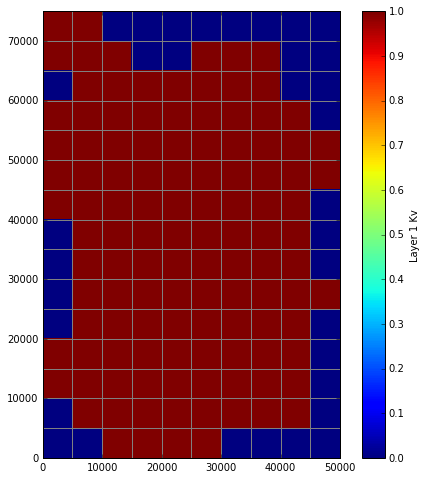

In [10]:
vksbndpth = os.path.join('..', 'data', 'uzf_examples', 'vks.dat')
vks = np.loadtxt(vksbndpth)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=m)
vksplt = modelmap.plot_array(vks)
plt.colorbar(vksplt, ax=ax, label='Layer 1 Kv')
linecollection = modelmap.plot_grid()

In [11]:
m2 = flopy.modflow.Modflow.load('UZFtest2.nam', version='mf2005', exe_name='mf2005', 
                               model_ws=path)

   loading iuzfbnd array...
   loading irunbnd array...
   loading vks array...
   loading eps array...
   loading thts array...
stress period 1:
   loading finf array...
   loading pet array...
   loading extdp array...
   loading extwc array...
stress period 2:
   loading finf array...
   loading pet array...
stress period 3:
   loading finf array...
stress period 4:
   loading finf array...
stress period 5:
   loading finf array...
stress period 6:
   loading finf array...
stress period 7:
   loading finf array...
stress period 8:
   loading finf array...
stress period 9:
   loading finf array...
stress period 10:
   loading finf array...
stress period 11:
   loading finf array...
stress period 12:
   loading finf array...


### `finf` array  
* load infiltration rates from a file into a 3D array
* `finf` can be submitted to FloPy as a 3D array, list of 2D arrays, list of numeric values, or single numeric value

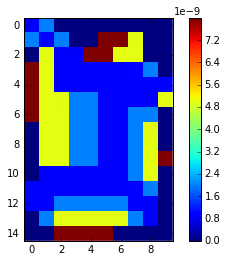

In [12]:
finf = np.loadtxt(os.path.join('..', 'data', 'uzf_examples', 'finf.dat'))
finf = np.reshape(finf, (m2.nper, m2.nrow, m2.ncol))
plt.imshow(finf[0], interpolation='none')
plt.colorbar()

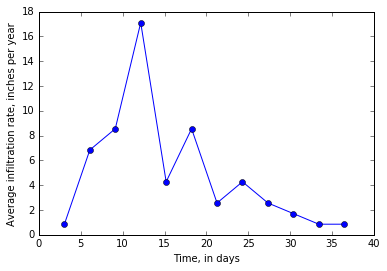

In [13]:
plt.plot(m2.dis.perlen.array.cumsum()/864600, 
         [a.mean() * 86400 * 365 * 12 for a in finf[:, :, :]], marker='o')
plt.xlabel('Time, in days')
plt.ylabel('Average infiltration rate, inches per year')

### Set up the gages (observation points)
* supplied as a dictionary keyed by `IFTUNIT`
* A positive value [of `IFTUNIT`] is for output of individual cells whereas a negative value is for output that is summed over all model cells. 
* values are a list of `[IUZROW, IUZCOL, IFTUNIT, IUZOPT]`

In [14]:
uzgag = {-68: [-68],
         65: [3, 6, 65, 1], #Print time, head, uz thickness and cum. vols of infiltration, recharge, storage, change in storage and ground-water discharge to land surface.
         66: [6, 3, 66, 2], #Same as option 1 except rates of infiltration, recharge, change in storage, and ground-water discharge also are printed.
         67: [10, 5, 67, 3]} #Prints time, ground-water head, thickness of unsaturated zone, followed by a series of depths and water contents in the unsaturated zone. 

### Make the UZF package

In [15]:
uzf = flopy.modflow.ModflowUzf1(m,
                                nuztop=1, iuzfopt=1, irunflg=1, ietflg=1,
                                iuzfcb1=0, 
                                iuzfcb2=61,# binary output of recharge and groundwater discharge
                                ntrail2=25, nsets=20, nuzgag=4,
                                surfdep=1.0, uzgag=uzgag,
                                iuzfbnd=m2.bas6.ibound.array, 
                                irunbnd=irunbnd, 
                                vks=vks, # saturated vertical hydraulic conductivity of the uz
                                finf=finf, #infiltration rates
                                eps=3.5, # Brooks-Corey relation of water content to hydraulic conductivity (epsilon)
                                thts = 0.35, # saturated water content of the uz in units of volume of water to total volume
                                pet=5.000000E-08, # potential ET
                                extdp=15., # ET extinction depth(s)
                                extwc=0.1 #extinction water content below which ET cannot be removed from the unsaturated zone
                                )

In [16]:
m.write_input()

#### run the model using the appropriate executable

## Results

### Look at the budget output

In [17]:
uzfbdobjct = bf.CellBudgetFile(path + '/UZFtest2.uzfbt2')
uzfbdobjct.textlist

[b'           GW ET', b'    UZF RECHARGE', b' SURFACE LEAKAGE']

../../flopy/utils/binaryfile.py:861: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  self.file.seek(ipos, 0)


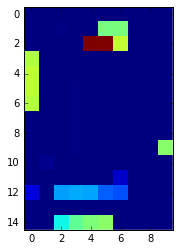

In [18]:
r = uzfbdobjct.get_data(text='UZF RECHARGE')
et = uzfbdobjct.get_data(text='GW ET')
plt.imshow(r[6], interpolation='None')

../../flopy/utils/binaryfile.py:861: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  self.file.seek(ipos, 0)


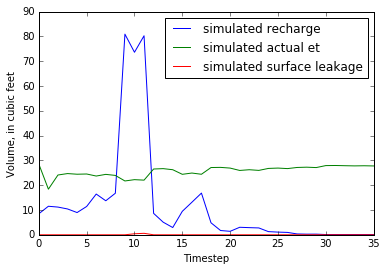

In [19]:
rtot = [rp.sum() for rp in r]
ettot = [etp.sum() for etp in et]
sltot = [sl.sum() for sl in uzfbdobjct.get_data(text='SURFACE LEAKAGE')]

plt.plot(rtot, label='simulated recharge')
plt.plot(np.abs(ettot), label='simulated actual et')
plt.plot(np.abs(sltot), label='simulated surface leakage')
plt.xlabel('Timestep')
plt.ylabel('Volume, in cubic feet')
plt.legend()

### Look at the gages

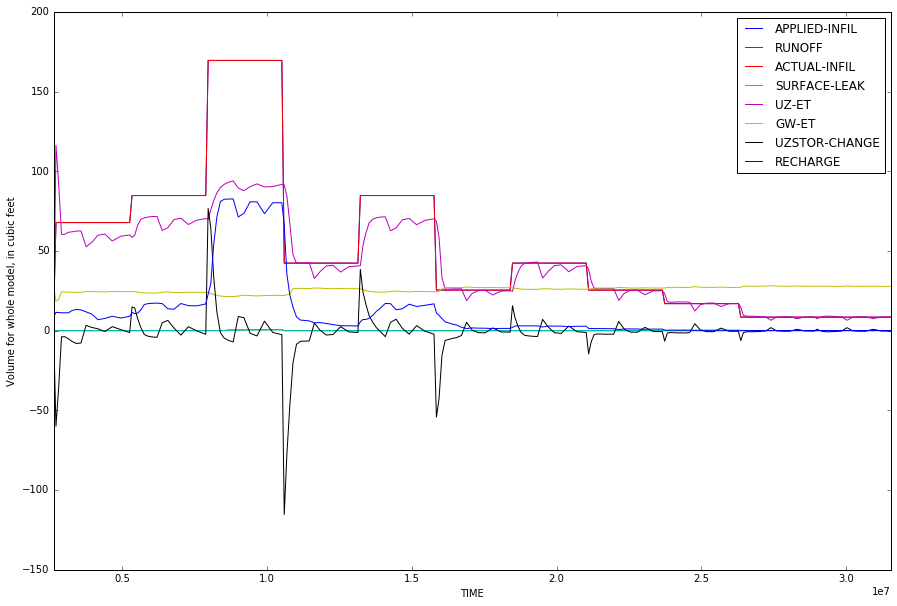

In [20]:
df = pd.read_csv(path + '/UZFtest2.uzfb3', skiprows=3, delim_whitespace=True, header=None,
           names=['TIME','APPLIED-INFIL','RUNOFF','ACTUAL-INFIL',
                  'SURFACE-LEAK','UZ-ET','GW-ET','UZSTOR-CHANGE','RECHARGE'],
                index_col=0)
ax = df.plot(legend=False, figsize=(15, 10))
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc=1)
ax.set_ylabel('Volume for whole model, in cubic feet')

### Plot water content profile through time at row 10, column 5

In [21]:
data = []
with open(path + '/UZFtest2.uzfb2') as input:
    for i in range(3):
        next(input)
    for line in input:
        line = line.strip().split()
        if len(line) == 6:
            layer = int(line.pop(0))
            time = float(line.pop(0))
            head = float(line.pop(0))
            uzthick = float(line.pop(0))
        depth = float(line.pop(0))
        watercontent = float(line.pop(0))
        data.append([layer, time, head, uzthick, depth, watercontent])

In [22]:
df3 = pd.DataFrame(data, columns=['layer', 'time', 'head', 'uzthick', 'depth', 'watercontent'])
df3.head(41)

,layer,time,head,uzthick,depth,watercontent
0,1,2628000.0,1036.0872,9.412842,0.235315,0.150654
1,1,2628000.0,1036.0872,9.412842,0.470630,0.150654
2,1,2628000.0,1036.0872,9.412842,0.705945,0.150654
3,1,2628000.0,1036.0872,9.412842,0.941261,0.150654
4,1,2628000.0,1036.0872,9.412842,1.176576,0.150654
5,1,2628000.0,1036.0872,9.412842,1.411891,0.150654
6,1,2628000.0,1036.0872,9.412842,1.647206,0.150654
7,1,2628000.0,1036.0872,9.412842,1.882521,0.150654
8,1,2628000.0,1036.0872,9.412842,2.117837,0.150654
9,1,2628000.0,1036.0872,9.412842,2.353152,0.150654


In [23]:
wc = df3.watercontent.reshape(len(df3.time.unique()), 40).T
wc = pd.DataFrame(wc, columns=df3.time.unique(), index=df3.depth[0:40])
wc.head()

,2628000.0,2710713.0,2801697.5,2901780.2,3011871.2,3132971.5,3266181.8,3412713.0,3573897.5,3751200.2,...,29546176.0,29692708.0,29853892.0,30031194.0,30226228.0,30440764.0,30676754.0,30936344.0,31221892.0,31535994.0
depth,,,,,,,,,,,,,,,,,,,,,
0.235315,0.150654,0.150909,0.150881,0.150851,0.150818,0.150781,0.150741,0.150696,0.150647,0.150889,...,0.150210,0.150166,0.150117,0.150359,0.150329,0.150296,0.150261,0.150366,0.150337,0.150305
0.470630,0.150654,0.150909,0.150881,0.150851,0.150818,0.150781,0.150741,0.150696,0.150647,0.150889,...,0.150210,0.150166,0.150117,0.150333,0.150329,0.150296,0.150261,0.150366,0.150337,0.150305
0.705945,0.150654,0.150909,0.150881,0.150851,0.150818,0.150781,0.150741,0.150696,0.150647,0.150889,...,0.150152,0.150127,0.150093,0.150000,0.150110,0.150119,0.150120,0.150096,0.150109,0.150117
0.941261,0.150654,0.150909,0.150881,0.150851,0.150818,0.150781,0.150741,0.150696,0.150647,0.150889,...,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000
1.176576,0.150654,0.150909,0.150881,0.150851,0.150818,0.150781,0.150741,0.150696,0.150647,0.150889,...,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000


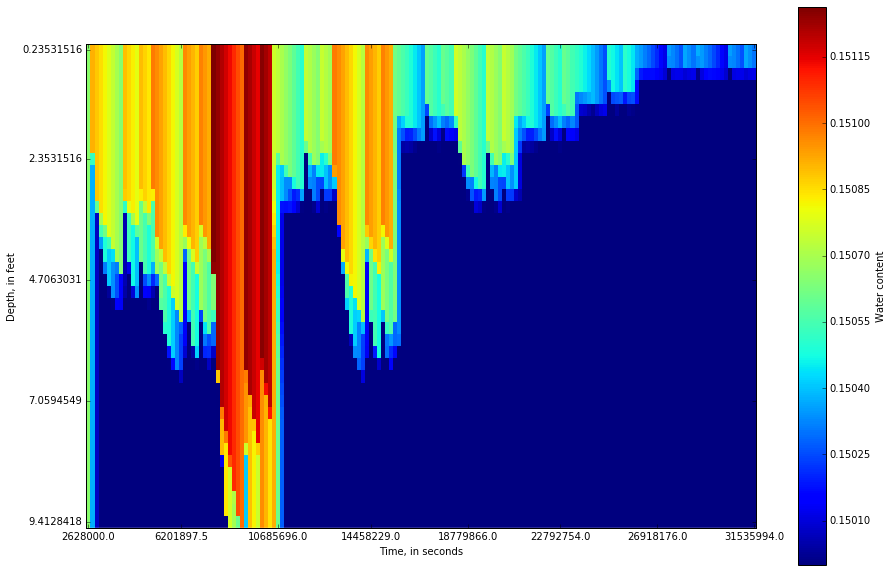

In [24]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.imshow(wc, interpolation='None')
ax.set_aspect(3)
r, c = wc.shape
xcol_locs = np.linspace(0, c-1, 8, dtype=int)
ycol_locs = np.linspace(0, r-1, 5, dtype=int)
ax.set_xticks(xcol_locs)

xlabels = wc.columns
ax.set_xticklabels(xlabels[xcol_locs])
ax.set_ylabel('Depth, in feet')
ax.set_yticks(ycol_locs)
ax.set_yticklabels(wc.index[ycol_locs])
ax.set_xlabel('Time, in seconds')
plt.colorbar(label='Water content')